In [1]:
import numpy as np
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
import time
import random

In [2]:
ELoad = pd.read_excel('data/electrical load/2015.xls')
PVLoad = pd.read_excel('data/PV/2015.xls')
PVirr = pd.read_csv('data/PV/irr.csv')
PVangle = pd.read_excel('data/PV/angle.xlsx')

In [3]:
ELoad = ELoad['MV'].values
PVLoad = PVLoad['MV'].values
PVirr = PVirr['irr'].values
PVangle = PVangle['angle'].values
PVangle = PVangle[list(range(0,96,4))]
PVangle = np.tile(PVangle,365)

In [4]:
PVirrH = np.cos(PVangle*np.pi/180)*PVirr
PVirrV = np.sin(PVangle*np.pi/180)*PVirr

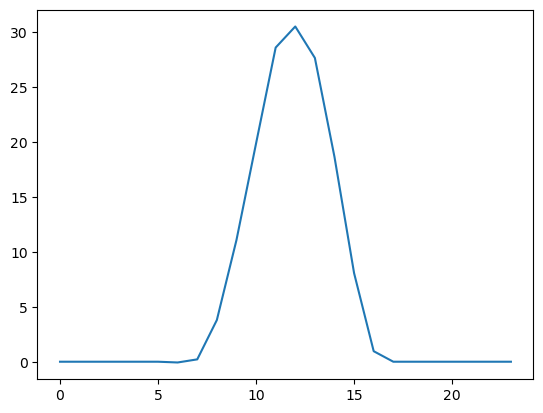

In [5]:
plt.plot(PVirrV[:24])

In [146]:
CCPV = 2000;
RCPV = 1700;
MCPV = 20;
LPV = 20;
AvPV = 0.96;
CCel = 2000;
RCel = 1500;
MCel = 25;
Lel = 20;
Avel = 1;
etael = 0.75;
CCHST = 1300;
RCHST = 1200;
MCHST = 15;
etaHST = 0.95;
LHST = 20;
AvHST = 1;
CCFC = 4000;
RCFC = 3500;
MCFC = 300;
etaFC = 0.5;
LFC = 5;
AvFC = 1;
CCin = 800;
RCin = 750;
MCin = 15;
etain = 0.9;
Lin = 15;
Avin = 1;
e0 = 0
HSTC = 2500*2;
ir = 0.06
year = 20;
pCoE = 0.4
lolmax = 0.01 # 0.1 or 0.01

In [147]:
PVLoad = PVLoad/PVLoad.max()*2500*2
ELoad = ELoad/ELoad.max()*200

In [148]:
print(PVLoad.sum())
ELoad.sum()

6832378.230227095


1253955.1991313733

In [149]:
KPV = sum(1/(1+ir)**(i*LPV) for i in range(1,2))
Kel = sum(1/(1+ir)**(i*Lel) for i in range(1,2))
KHST = sum(1/(1+ir)**(i*LHST) for i in range(1,2))
KFC = sum(1/(1+ir)**(i*LFC) for i in range(1,4+1))

In [150]:
PWA  = ((1+ir)**year-1)/(ir*(1+ir)**year)
PWA

11.469921218565263

In [151]:
def LOLy(x):
    npv=x[0]
    mt = x[1]
    tpv = x[2]
    irr_to_panels = PVirrH*np.sin(tpv)+PVirrV*np.cos(tpv)
    PPV = irr_to_panels/1000*350*0.95*npv
    t = 8760
    P_FC = np.zeros((t))
    P_el = np.zeros((t))
    lol = np.zeros((t))
    EHST = np.zeros((t))
    
    for i in range(t):
        if i == 0:
            EHST[i]=e0
        else:
            if PPV[i]-ELoad[i]>0:
                if EHST[i-1] + etael*(PPV[i]-ELoad[i])<mt*39.7:
                    EHST[i] = EHST[i-1] + etael*(PPV[i]-ELoad[i])
                    P_el[i] = PPV[i]-ELoad[i]
                else:
                    EHST[i] = mt*39.7
                    P_el[i] = (mt*39.7-EHST[i-1])/etael
            else:
                if EHST[i-1] + (PPV[i]-ELoad[i])/etaFC*etaHST >0:
                    EHST[i] = EHST[i-1] + (PPV[i]-ELoad[i])/etaFC*etaHST
                    P_FC[i] = (EHST[i-1]-EHST[i])/etaHST*etaFC
                else:
                    EHST[i] = 0
                    P_FC[i] = (EHST[i-1]-EHST[i])/etaHST*etaFC
            l = ELoad[i] + P_el[i] - PPV[i]- P_FC[i]
            if l>0:
                lol[i] = l
    CC = CCPV*PPV.max() + CCel*P_el.max() + CCFC*P_FC.max() + CCHST * mt
    RC = 3*RCFC*P_FC.max()*KFC
    MC = (MCPV+PPV.max() + MCel*P_el.max() + MCFC*P_FC.max() + MCHST * mt)*PWA
    NPC = CC + RC + MC
    NPCLoss = CoE*sum(lol)*PWA
    if sum(lol)/sum(ELoad)<lolmax:
        penalty = 0
    else:
        penalty = (sum(lol)/sum(ELoad)-lolmax)*1e17
    Cost = NPC + NPCLoss + penalty
    return Cost
    

In [152]:
class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual=[]
        self.convergence = []
        self.optimizer=""
        self.objfname=""
        self.startTime=0
        self.endTime=0
        self.executionTime=0
        self.lb=0
        self.ub=0
        self.dim=0
        self.popnum=0
        self.maxiers=0

In [153]:
def GWO(objf,lb,ub,dim,SearchAgents_no,Max_iter):
    
    
    #Max_iter=1000
    #lb=-100
    #ub=100
    #dim=30  
    #SearchAgents_no=5
    
    # initialize alpha, beta, and delta_pos
    Alpha_pos=np.zeros(dim)
    Alpha_score=float("inf")
    
    Beta_pos=np.zeros(dim)
    Beta_score=float("inf")
    
    Delta_pos=np.zeros(dim)
    Delta_score=float("inf")

    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    
    #Initialize the positions of search agents
    Positions = np.zeros((SearchAgents_no, dim))
    for i in range(dim):
        Positions[:, i] = np.random.uniform(0,1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i]
    
    Convergence_curve=np.zeros(Max_iter)
    s=solution()
     # Loop counter
    print("GWO is optimizing  \""+objf.__name__+"\"")    
    
    timerStart=time.time() 
    s.startTime=time.strftime("%Y-%m-%d-%H-%M-%S")
    # Main loop
    for l in range(0,Max_iter):
        for i in range(0,SearchAgents_no):
            
            # Return back the search agents that go beyond the boundaries of the search space
            for j in range(dim):
                Positions[i,j]=np.clip(Positions[i,j], lb[j], ub[j])

            # Calculate objective function for each search agent
            fitness=objf(Positions[i,:])
            
            # Update Alpha, Beta, and Delta
            if fitness<Alpha_score :
                Delta_score=Beta_score  # Update delte
                Delta_pos=Beta_pos.copy()
                Beta_score=Alpha_score  # Update beta
                Beta_pos=Alpha_pos.copy()
                Alpha_score=fitness; # Update alpha
                Alpha_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness<Beta_score ):
                Delta_score=Beta_score  # Update delte
                Delta_pos=Beta_pos.copy()
                Beta_score=fitness  # Update beta
                Beta_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness>Beta_score and fitness<Delta_score):                 
                Delta_score=fitness # Update delta
                Delta_pos=Positions[i,:].copy()
            
        
        
        
        a=2-l*((2)/Max_iter); # a decreases linearly fron 2 to 0
        
        # Update the Position of search agents including omegas
        for i in range(0,SearchAgents_no):
            for j in range (0,dim):     
                           
                r1=random.random() # r1 is a random number in [0,1]
                r2=random.random() # r2 is a random number in [0,1]
                
                A1=2*a*r1-a; # Equation (3.3)
                C1=2*r2; # Equation (3.4)
                
                D_alpha=abs(C1*Alpha_pos[j]-Positions[i,j]); # Equation (3.5)-part 1
                X1=Alpha_pos[j]-A1*D_alpha; # Equation (3.6)-part 1
                           
                r1=random.random()
                r2=random.random()
                
                A2=2*a*r1-a; # Equation (3.3)
                C2=2*r2; # Equation (3.4)
                
                D_beta=abs(C2*Beta_pos[j]-Positions[i,j]); # Equation (3.5)-part 2
                X2=Beta_pos[j]-A2*D_beta; # Equation (3.6)-part 2       
                
                r1=random.random()
                r2=random.random() 
                
                A3=2*a*r1-a; # Equation (3.3)
                C3=2*r2; # Equation (3.4)
                
                D_delta=abs(C3*Delta_pos[j]-Positions[i,j]); # Equation (3.5)-part 3
                X3=Delta_pos[j]-A3*D_delta; # Equation (3.5)-part 3             
                
                Positions[i,j]=(X1+X2+X3)/3  # Equation (3.7)
                
            
        
        
        Convergence_curve[l]=Alpha_score;

        #if (l%1==0):
               #print(['At iteration '+ str(l)+ ' the best fitness is '+ str(Alpha_score)]);
    
    timerEnd=time.time()  
    s.endTime=time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime=timerEnd-timerStart
    s.convergence=Convergence_curve
    s.optimizer="GWO"
    s.objfname=objf.__name__
    s.best = list(Alpha_pos)
    
    
    
    
    return s

In [154]:
lb = [0, 0 ,0]
ub = [5000,1000,np.pi/2]
dim = 3
SearchAgents_no = 100
Max_iter = 500

In [155]:
s = GWO(LOLy,lb,ub,dim,SearchAgents_no,Max_iter)

GWO is optimizing  "LOLy"


In [156]:
s.best

[128.31515521899883, 382.25229461338114, 0.47690520872942166]

In [157]:
0.4195350494022383

0.4195350494022383

In [158]:
s.best[2]*180/np.pi

27.324655688001446

In [159]:
s.executionTime

2300.8973643779755

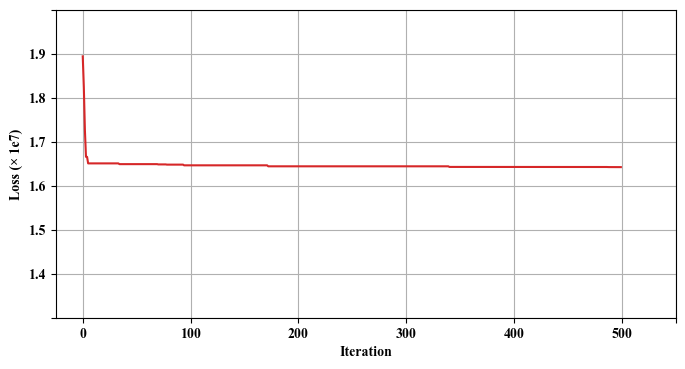

In [170]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.plot(s.convergence,color='#d62728')
plt.xlabel('Iteration',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Loss (\u00d7 1e7)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([1.3e7, 1.4e7, 1.5e7, 1.6e7 ,1.7e7, 1.8e7, 1.9e7, 2e7], ['', '1.4', '1.5', '1.6' ,'1.7', '1.8', '1.9', ''],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 100, 200, 300, 400, 500, 550],
           ['0', '100', '200', '300', '400', '500', ''],
           fontname='Times New Roman',fontsize = 10, fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

In [161]:
def LOLyc(x):
    npv=x[0]
    mt = x[1]
    tpv = x[2]
    irr_to_panels = PVirrH*np.sin(tpv)+PVirrV*np.cos(tpv)
    PPV = irr_to_panels/1000*350*0.95*npv
    t = 8760
    P_FC = np.zeros((t))
    P_el = np.zeros((t))
    lol = np.zeros((t))
    EHST = np.zeros((t))
    
    for i in range(t):
        if i == 0:
            EHST[i]=e0
        else:
            if PPV[i]-ELoad[i]>0:
                if EHST[i-1] + etael*(PPV[i]-ELoad[i])<mt*39.7:
                    EHST[i] = EHST[i-1] + etael*(PPV[i]-ELoad[i])
                    P_el[i] = PPV[i]-ELoad[i]
                else:
                    EHST[i] = mt*39.7
                    P_el[i] = (mt*39.7-EHST[i-1])/etael
            else:
                if EHST[i-1] + (PPV[i]-ELoad[i])/etaFC*etaHST >0:
                    EHST[i] = EHST[i-1] + (PPV[i]-ELoad[i])/etaFC*etaHST
                    P_FC[i] = (EHST[i-1]-EHST[i])/etaHST*etaFC
                else:
                    EHST[i] = 0
                    P_FC[i] = (EHST[i-1]-EHST[i])/etaHST*etaFC
            l = ELoad[i] + P_el[i] - PPV[i]- P_FC[i]
            if l>0:
                lol[i] = l
    print(P_FC.max())
    print(PPV.max())
    print(P_el.max())
    print(ELoad.max())
    CC = CCPV*PPV.max() + CCel*P_el.max() + CCFC*P_FC.max() + CCHST * mt
    RC = 3*RCFC*P_FC.max()*KFC
    MC = (MCPV+PPV.max() + MCel*P_el.max() + MCFC*P_FC.max() + MCHST * mt)*PWA
    NPC = CC + RC + MC
    NPCLoss = CoE*sum(lol)*PWA
    if sum(lol)/sum(ELoad)<lolmax:
        penalty = 0
    else:
        penalty = (sum(lol)/sum(ELoad)-lolmax)*1e17
    print(penalty)
    print(sum(lol)/sum(ELoad))
    print(NPCLoss)
    print('CC = ',CC)
    print('RC = ',RC)
    print('MC = ',MC)
    Cost = NPC + NPCLoss + penalty
    print (Cost)
    print(sum(lol))
    return EHST

In [162]:
EHST = LOLyc(s.best)

200.0
2706.9015924421483
2009.9581071411471
200.0
0
0.009998556199870138
57522.763046043925
CC =  10730647.382163987
RC =  4272917.7485458795
MC =  1361590.2036606146
16422678.097416524
12537.741530634345


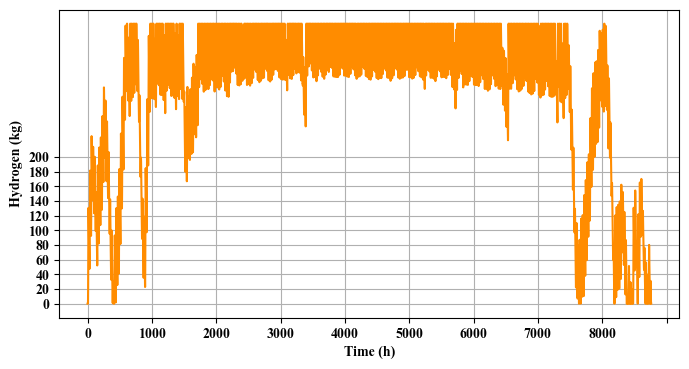

In [163]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.plot([i/39.7 for i in EHST], color='#FF8C00')
plt.xlabel('Time (h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Hydrogen (kg)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([0, 20, 40, 60 , 80, 100, 120, 140, 160, 180 , 200], 
           ['0', '20', '40', '60' , '80', '100', '120', '140', '160', '180' , '200'],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
           ['0', '1000', '2000', '3000', '4000', '5000', '6000', '7000', '8000', ' '],
           fontname='Times New Roman',fontsize = 10, fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

In [164]:
t = 8760
EHST = np.zeros((t))
for i in range(t):
    if i == 0:
        EHST[i]=e0
    else:
        if PVLoad[i]-ELoad[i]>0:
            if EHST[i-1] + etael*(PVLoad[i]-ELoad[i])<HSTC:
                EHST[i] = EHST[i-1] + etael*(PVLoad[i]-ELoad[i])
            else:
                EHST[i] = HSTC
        else:
            if EHST[i-1] + (PVLoad[i]-ELoad[i])/etaFC*etaHST >0:
                EHST[i] = EHST[i-1] + (PVLoad[i]-ELoad[i])/etaFC*etaHST
            else:
                EHST[i] = 0

In [165]:
def P_FC(t):
    if EHST[t-1]-EHST[t]>0:
        return (EHST[t-1]-EHST[t])/etaHST*etaFC
    else:
        return 0

In [166]:
def P_El(t):
    if EHST[t-1]-EHST[t]<0:
        return -(EHST[t-1]-EHST[t])/etael
    else:
        return 0

In [167]:
def LOL(t):
    l = ELoad[t] + P_El(t) - PVLoad[t]- P_FC(t)
    if l<0:
        l = 0
    return l